![Julia EO 2023 Banner](figures/JuliaEO_banner.png "Julia EO 2023 Banner")


In this hands-on workshop, we will introduce the [SARprocessing.jl](https://github.com/AIRCentre/SARProcessing.jl) package and see how it can be used to work with Sentinel-1 SAR images. 

This hand-on is somewhat an extention of the [Introduction of SAR, presented at JuliaEO 2023](https://docs.google.com/presentation/d/12AQOnHRXWz2IuHeFa5BzQVscsoty3fD-PnbxI-XKmGo/edit?usp=sharing). However, we assume no privious knowlegde of SAR data in this notebook.

In the privious notebook, you used the SARprocessing package to load an image and speckle filter it. In this one we will look for objects in the image.




## Table Of Contents
-  Include and Introduce SARProcessing.jl
-  Load and show Image
-  Speckle Reduction
-  [Object Detection in SAR images](#CFAR)
-  Interferometry



Firstly, loading the packaged that we will need.

In [1]:
using SARProcessing;
using Plots;

In [2]:
slcSubsetPath = "../data/s1a-iw3-slc-vv_subset_hight9800_10400_width11000_11000.tiff";
slc_image = abs.(SARProcessing.load_tiff(slcSubsetPath));

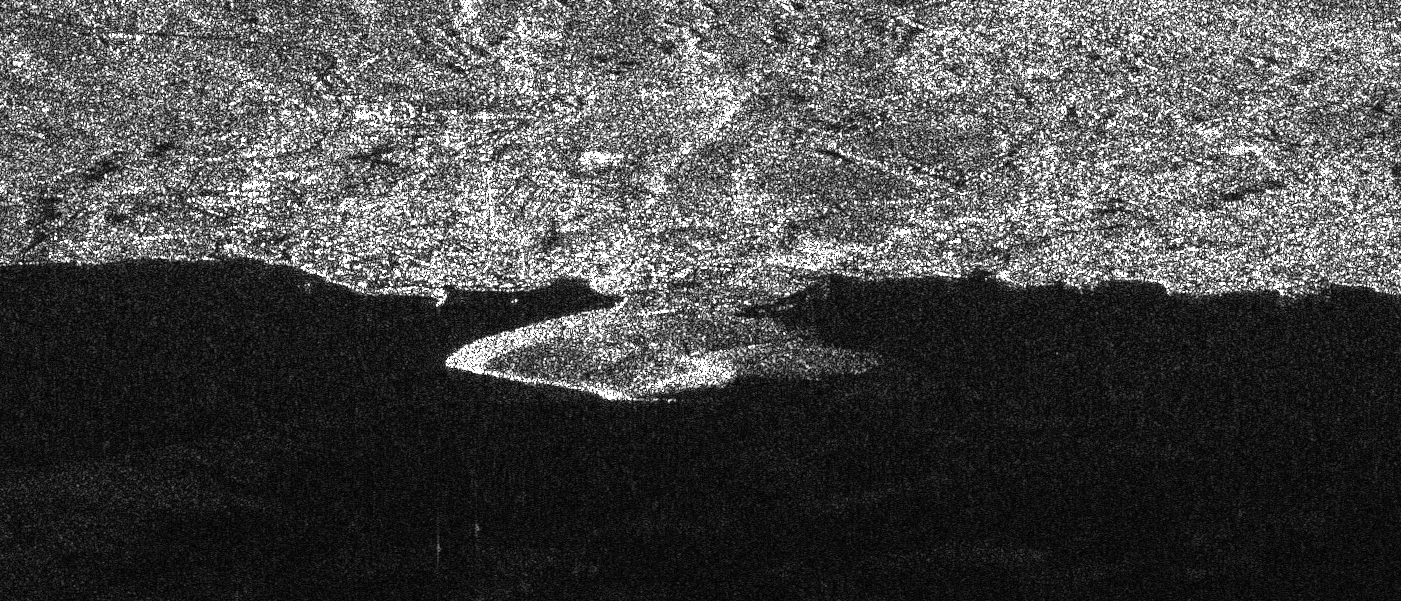

In [3]:
SARProcessing.sar2gray(slc_image, p_quantile = 0.95)

# Object detection
 <a class="anchor" id="cfar"></a>


Object detection is used in many fiels of earth observation in both the land and maritime enviroment. For the maritime enviroment, it is used in great extent for, e.g., iceberg detection or ship detection. Often, object detection is used as a priliminary analysis whereafter the detected objects are classified as belonging to different classes. 

In the following section we will

- Use CA-CFAR and CP-CFAR object detectors to find objects in an image
- Extract the locations of the objects
- Extract a subset of the objects

![Julia EO 2023 Banner](figures/detect_ship.png "Julia EO 2023 Banner")


### CFAR
 <a class="anchor" id="CFAR"></a>

Generally, adaptive object detectors based on thresholds are made to find pixel values that are brighter than the surrounding pixels. An adaptive threshold is set based on the local statistics. If a given pixel has a higher value than the adaptive threshold, it is an object. One such threshold is the Constant False Alarm Rate (CFAR), applicable when one is looking for a specific intensity structure. For CFAR, the statistics is computed from a background box, as shown below and compared to the statistics of the Region of Interest(ROI). 


![CFAR windows](figures/cfar_windows.png "CFAR windows")


### CA-CFAR
 <a class="anchor" id="ca_cfar"></a>


A more advanced two-parameter CFAR utilises two parameters for finding objects and is explained in Ref. (Crisp, 2004). A so-called adaptive threshold algorithm using a background, a guard, and a target window is used. All three windows are applied on the entire image, one shifting pixel at a time. The Background window is used to calculate the statistics of the surrounding homogeneous area.

The threshold is set by ensuring that the probability of false alarms is constant, hence Probability of False Alarms (PFA). The threshold is chosen such that the percentage of background pixel values above the threshold is constant. We will therefore get a constant number of false alarms per unit area of the image. Therefore the name, Constant False Alarm Rate (CFAR). Here, the background area samples are used to estimate the parameters instead of using the entire image.  

The ROI is an object if

$ x_t > T,$  
where $x_t$ is the pixel in the target box and T the threshold. If we assume a gaussian distribution for the CFAR detector,  we have:

$ x_t > \mu_b + \sigma_b t,$ 

where $t$ is found from the PFA. Therfore the name two-paramter CFAR. 
If we are looking at a groupt of pixels (a cell), we have the Cell-Averaging CFAR (CA-CFAR) with

$ t_{CA} = t/\sqrt(N)$ 

where $N$ is the number of pixels in the target window since averaging N samples from a Gaussian distribution with $\mu$ and $\sigma$ produces another Gaussain distribution with $\mu$ and standard deviation $\sigma / \sqrt(N)$

The size of both the guard and background(clutter) windows must therefore be defined. Likewise should the probability for false alarms (PFA) 

In [4]:
background_window = 12; 
guard_window = 7;
probability_for_alarms = 10^(-12);
target_window=3;

Lets use the CA-CFAR to find objects in the image

In [5]:
image_ca_cfar = SARProcessing.cell_averaging_constant_false_alarm_rate(slc_image.^2,background_window,guard_window,target_window,probability_for_alarms);

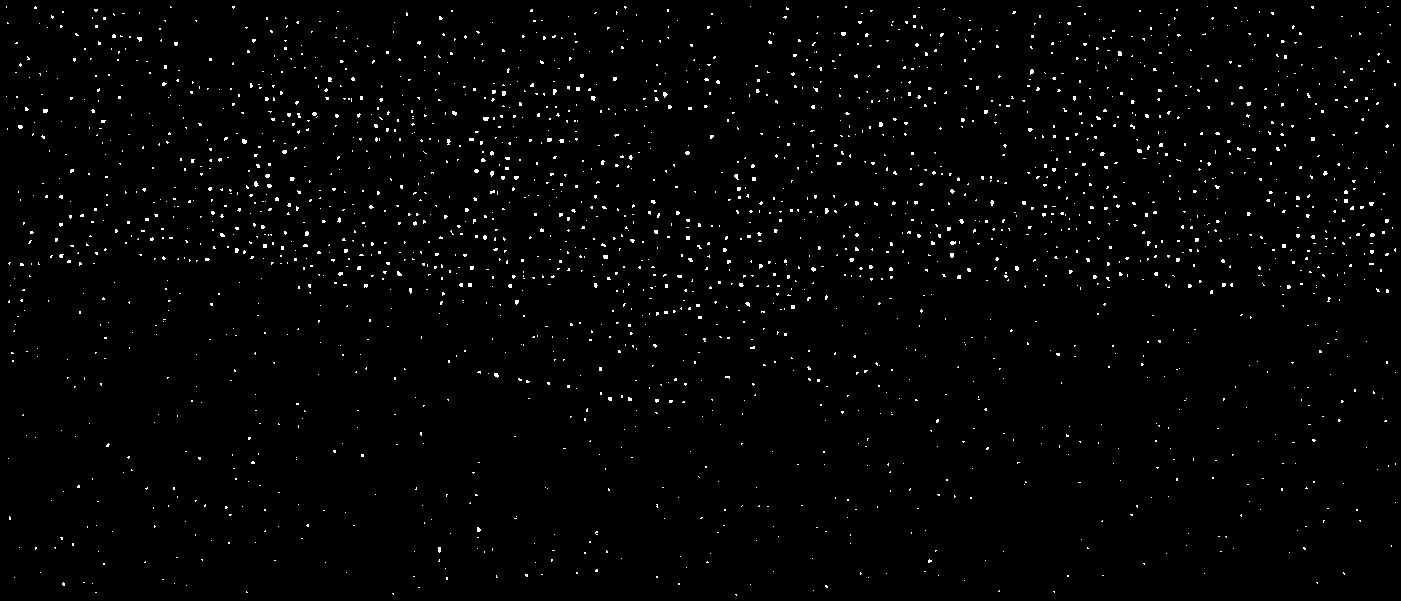

In [6]:
SARProcessing.sar2gray(image_ca_cfar, p_quantile = 0.95)

### CP-CFAR
<a class="anchor" id="cp_cfar"></a>

The constant false alarm rate with convolution and pooling (CP-CFAR), described in *SAR Target CFAR Detection Via GPU Parallel Operation, Zongyong Cui et al, 2018,* utilizes morphological operations to reduce the number of false alarms and increase computation speed.

![CP-CFAR](figures/cp_cfar.png "CP-CFAR")


**Question**: Try to implement the constant_false_alarm_rate_with_convolution_and_pooling (CP-CFAR) algorithm and show the results. Hint, find it somewhere in the [SARprocessing.jl](https://github.com/AIRCentre/SARProcessing.jl) package..

In [7]:
image_cp_cfar = SARProcessing.constant_false_alarm_rate_with_convolution_and_pooling(slc_image.^2,background_window,guard_window,probability_for_alarms);

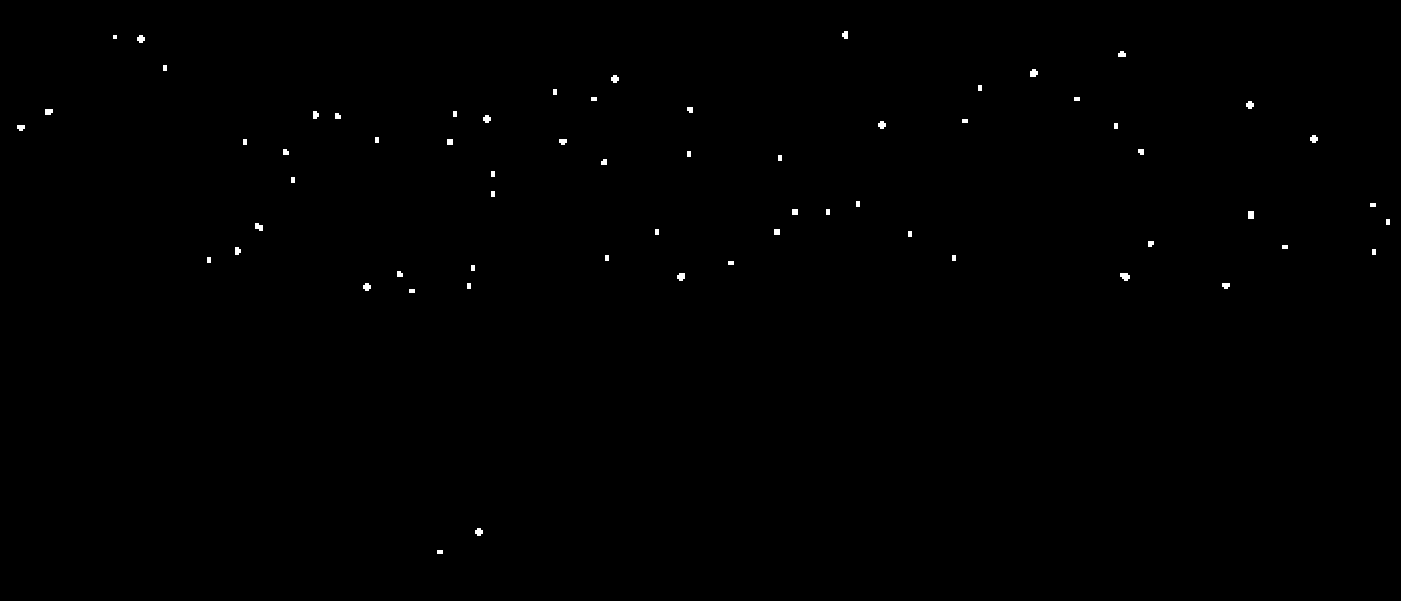

In [8]:
SARProcessing.sar2gray(image_cp_cfar, p_quantile = 0.95)

**Question**: What if we did speckle filtering before?

### Location of objects
<a class="anchor" id="Location_of_subsets"></a>

We now want to find the locations of the objects. The SARProcessing.object_locations function find the center location of each object.

In [9]:
index_cp = SARProcessing.object_locations(image_cp_cfar);
index_ca = SARProcessing.object_locations(image_ca_cfar);

Illustrating the locations of the objects using CA-CFAR and CP-CFAR respectivly. 

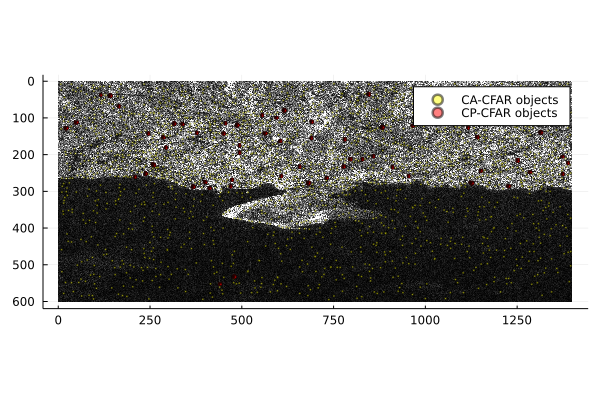

In [10]:
heatmap(SARProcessing.sar2gray(slc_image, p_quantile = 0.95))
plot!(convert.(Float64,last.(index_ca)),convert.(Float64,first.(index_ca)), seriestype=:scatter, label="CA-CFAR objects", mc=:yellow, ms=2, ma=0.5)
plot!(convert.(Float64,last.(index_cp)),convert.(Float64,first.(index_cp)), seriestype=:scatter, label="CP-CFAR objects", mc=:red, ms=2, ma=0.5)

### getting subset of object

In [11]:
index = findall(first.(index_cp) .== maximum(first.(index_cp)) );
subset = SARProcessing.get_subset(slc_image,index_cp[index][1] ,[55,55]);
subset2 = SARProcessing.get_subset(slc_image,index_cp[50] ,[55,55]);

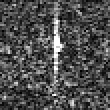

In [12]:
SARProcessing.sar2gray(subset[:,:,1], p_quantile = 0.99)


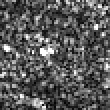

In [13]:
SARProcessing.sar2gray(subset2[:,:,1], p_quantile = 0.99)